# Add Necessary Directories to Path Variable

In [1]:
import os
import sys
home_dir="/home/paperspace/"
module_path = (os.path.join(home_dir+'Mask_RCNN-master/'),
               os.path.join(home_dir+'cocoapi/PythonAPI/'), 
               os.path.join(home_dir+'cocoapi/PythonAPI/pycocotools/'), 
               os.path.join(home_dir+'Mask_RCNN-master/samples/driving'))
for p in module_path:
  if p not in sys.path:
    sys.path.append(p)

In [2]:
#import os
#os.environ['PATH'] = os.environ['PATH']+os.path.expanduser((':content/drive/Kaggle/Mask_RCNN-master/:/content/drive/Kaggle/coco-master/PythonAPI/:/content/drive/Kaggle/coco-master/PythonAPI/pycocotools/:/content/drive/Kaggle/Mask_RCNN-master/samples/nucli'))

In [3]:
#print(os.environ['PATH'])

/home/paperspace/anaconda3/envs/fastai/bin:/home/paperspace/bin:/home/paperspace/.local/bin:/home/paperspace/google-cloud-sdk/bin:/home/paperspace/anaconda3/envs/fastai/bin:/home/paperspace/anaconda3/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:content/drive/Kaggle/Mask_RCNN-master/:/content/drive/Kaggle/coco-master/PythonAPI/:/content/drive/Kaggle/coco-master/PythonAPI/pycocotools/:/content/drive/Kaggle/Mask_RCNN-master/samples/nucli


In [2]:
import os
os.chdir(os.path.join(home_dir, 'Mask_RCNN-master/samples/driving'))

In [3]:
!ls ../../

assets	    inspect_data.ipynb	   mask_rcnn_coco.h5  samples
coco.py     inspect_model.ipynb    model.py	      shapes.py
config.py   inspect_weights.ipynb  parallel_model.py  train_shapes.ipynb
demo.ipynb  LICENSE		   __pycache__	      utils.py
images	    logs		   README.md	      visualize.py


# Mask R-CNN - Inspect WAD Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [4]:
%load_ext autoreload


In [15]:
%autoreload 2

import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.join(home_dir, 'Mask_RCNN-master/samples/driving') #os.getcwd()
if ROOT_DIR.endswith("samples/driving"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

import wad_tools

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
WAD_WEIGHTS_PATH = os.path.join(ROOT_DIR, "samples/driving", "mask_rcnn_wad_0069.h5")  # TODO: update this path
COCO_WEIGHTS_PATH = None
print('ROOT_DIR',ROOT_DIR)

ROOT_DIR /home/paperspace/Mask_RCNN-master


## Configurations

In [9]:
config = wad_tools.WADConfig()
WAD_DIR = os.path.join(home_dir, "data/wad")

In [10]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DATASET_DICT                   {'train': {'images': 'train_color', 'labels': 'train_label'}, 'test': {'images': 'test', 'labels': None}}
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IGNORE_CATS_LIST               [0, 255]
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_DATASET_SIZE               150
MAX_GT_INSTANCES               100
MEAN

## Notebook Preferences

In [11]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [12]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [13]:
# Load validation dataset
labels_file = "/home/paperspace/data/wad/wad_labels.csv"
dataset = wad_tools.WADDataset(labels_file, config.DATASET_DICT, ignore_cats=config.IGNORE_CATS_LIST)
dataset.load_wad(WAD_DIR, "train", num_images=50)

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

100%|██████████| 50/50 [00:11<00:00,  4.22images/s]

Images: 50
Classes: ['BG', 'car', 'motorbicycle', 'bicycle', 'person', 'rider', 'truck', 'bus', 'tricycle', 'others', 'rover', 'sky', 'car_groups', 'motorbicycle_group', 'bicycle_group', 'person_group', 'rider_group', 'truck_group', 'bus_group', 'tricycle_group', 'road', 'siderwalk', 'traffic_cone', 'road_pile', 'fence', 'traffic_light', 'pole', 'traffic_sign', 'wall', 'dustbin', 'billboard', 'building', 'bridge', 'tunnel', 'overpass', 'vegatation', 'unlabeled']


## Load Model

In [14]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [16]:
# Set path to nucli weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = WAD_WEIGHTS_PATH

# Or, load the last model you trained
#weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
if weights_path == COCO_WEIGHTS_PATH:
    model.load_weights(weights_path, by_name=True, exclude=[
                "mrcnn_class_logits", "mrcnn_bbox_fc",
                "mrcnn_bbox", "mrcnn_mask"])
else:
    model.load_weights(weights_path, by_name=True)

Loading weights  /home/paperspace/Mask_RCNN-master/samples/driving/mask_rcnn_wad_0069.h5


## Run Detection

image ID: WAD.170908_065617183_Camera_6 (34) /home/paperspace/data/wad
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 45)               min:    0.00000  max: 1024.00000


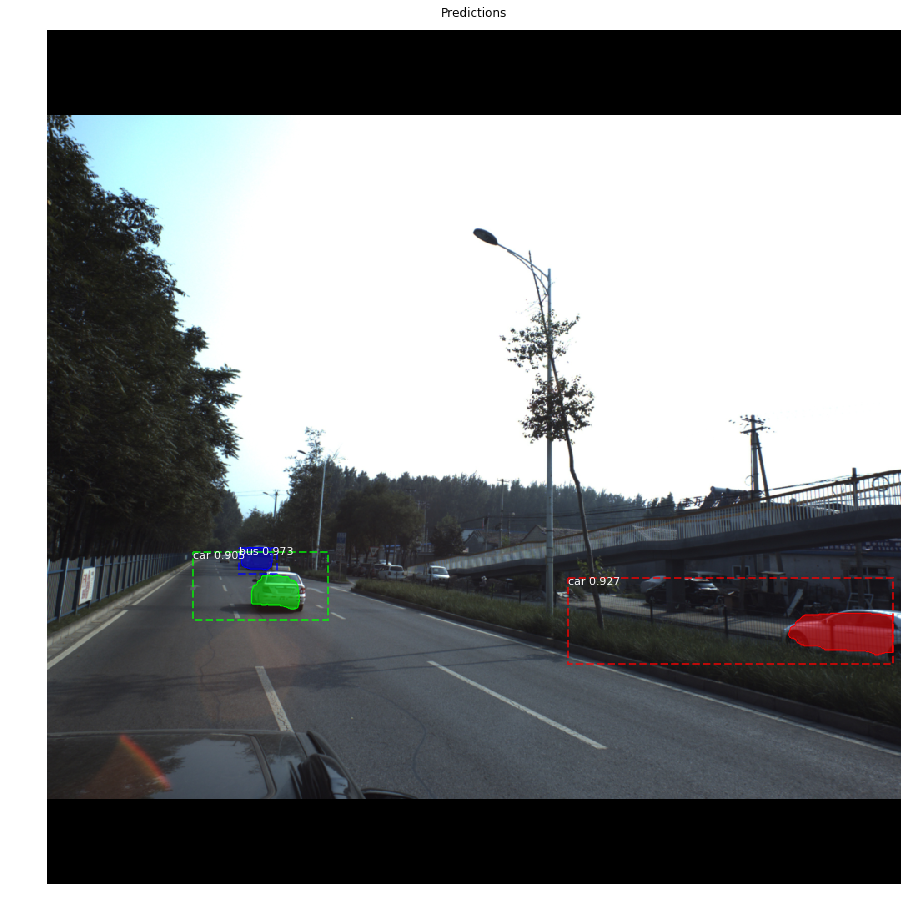

In [26]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
#image = dataset.load_image(image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

## Color Splash

This is for illustration. You can call `wad_tools.py` with the `splash` option to get better images without the black padding.

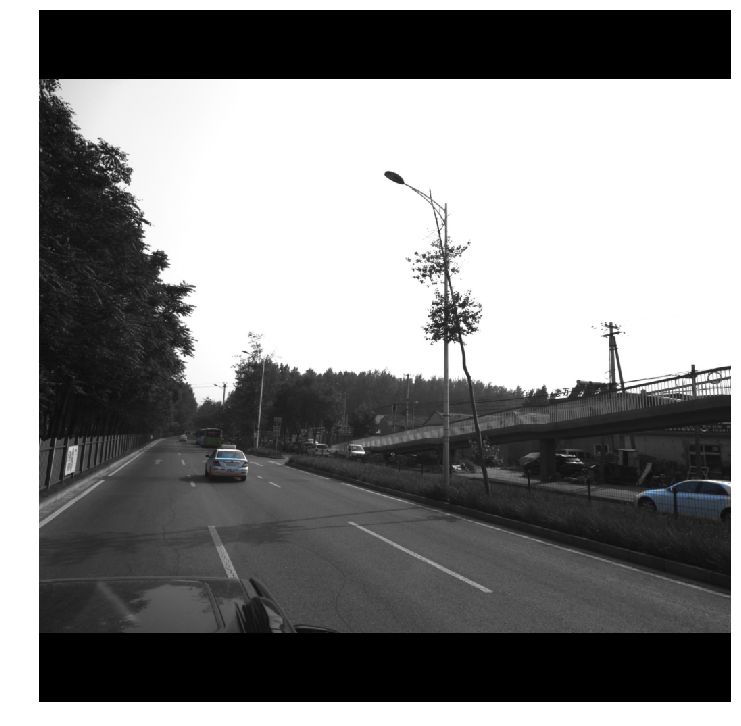

In [27]:
splash = wad_tools.color_splash(image, r['masks'])
display_images([splash], cols=1)

## Get all Test 

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [28]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:  -23.42291  max:   11.49049
positive_anchors         shape: (21, 4)               min:  224.68629  max:  950.62742
negative_anchors         shape: (235, 4)              min:  -64.00000  max: 1072.00000
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867
refined_anchors          shape: (21, 4)               min:  223.99988  max: 1024.00000


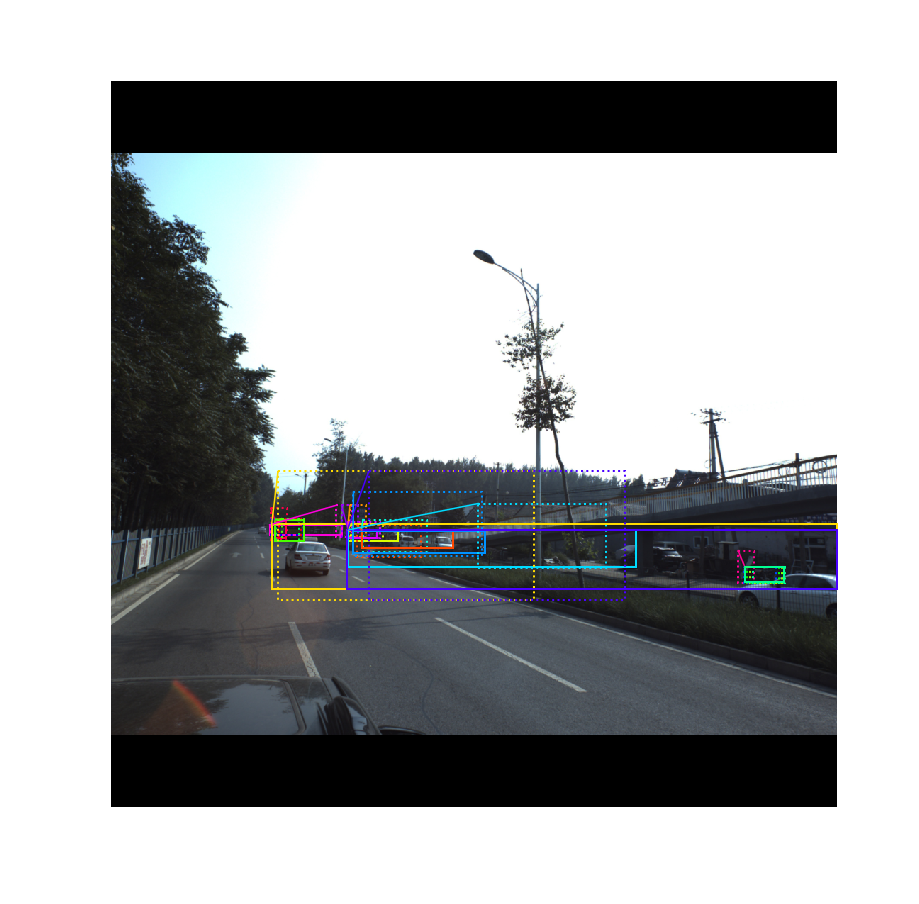

In [29]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [30]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 6000, 4)          min: -298.03867  max: 1322.03870
refined_anchors          shape: (1, 6000, 4)          min: -672.77014  max: 2050.99072
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max: 1024.00000
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 3377.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


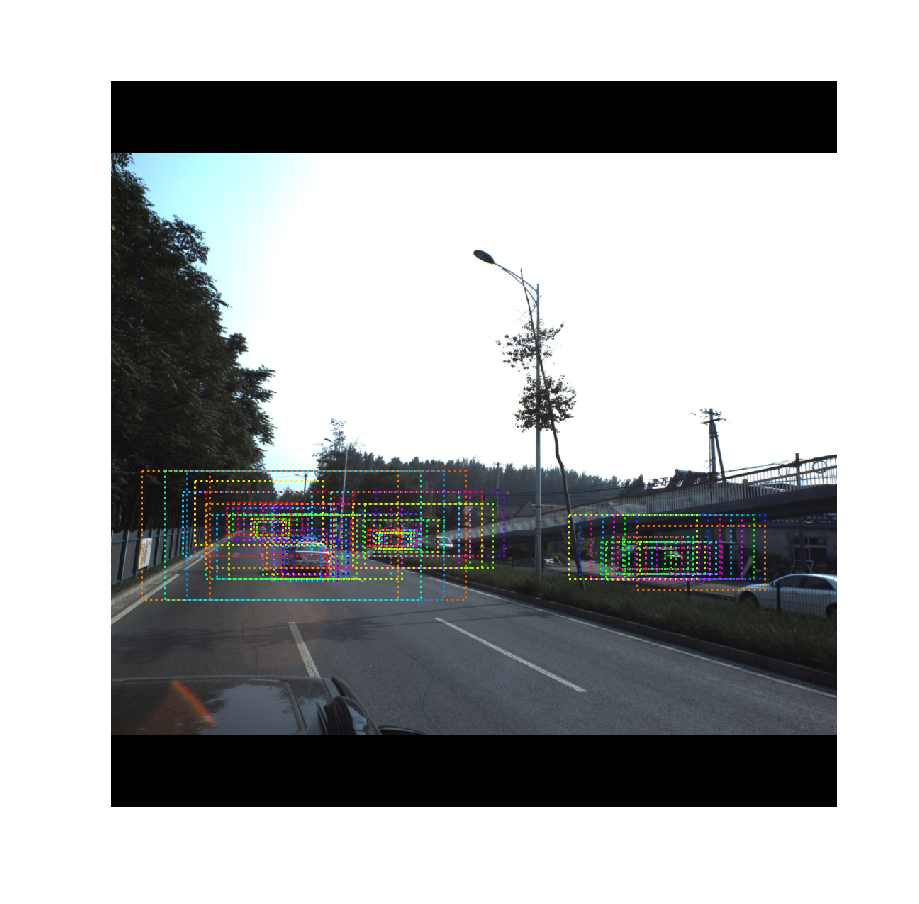

In [31]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

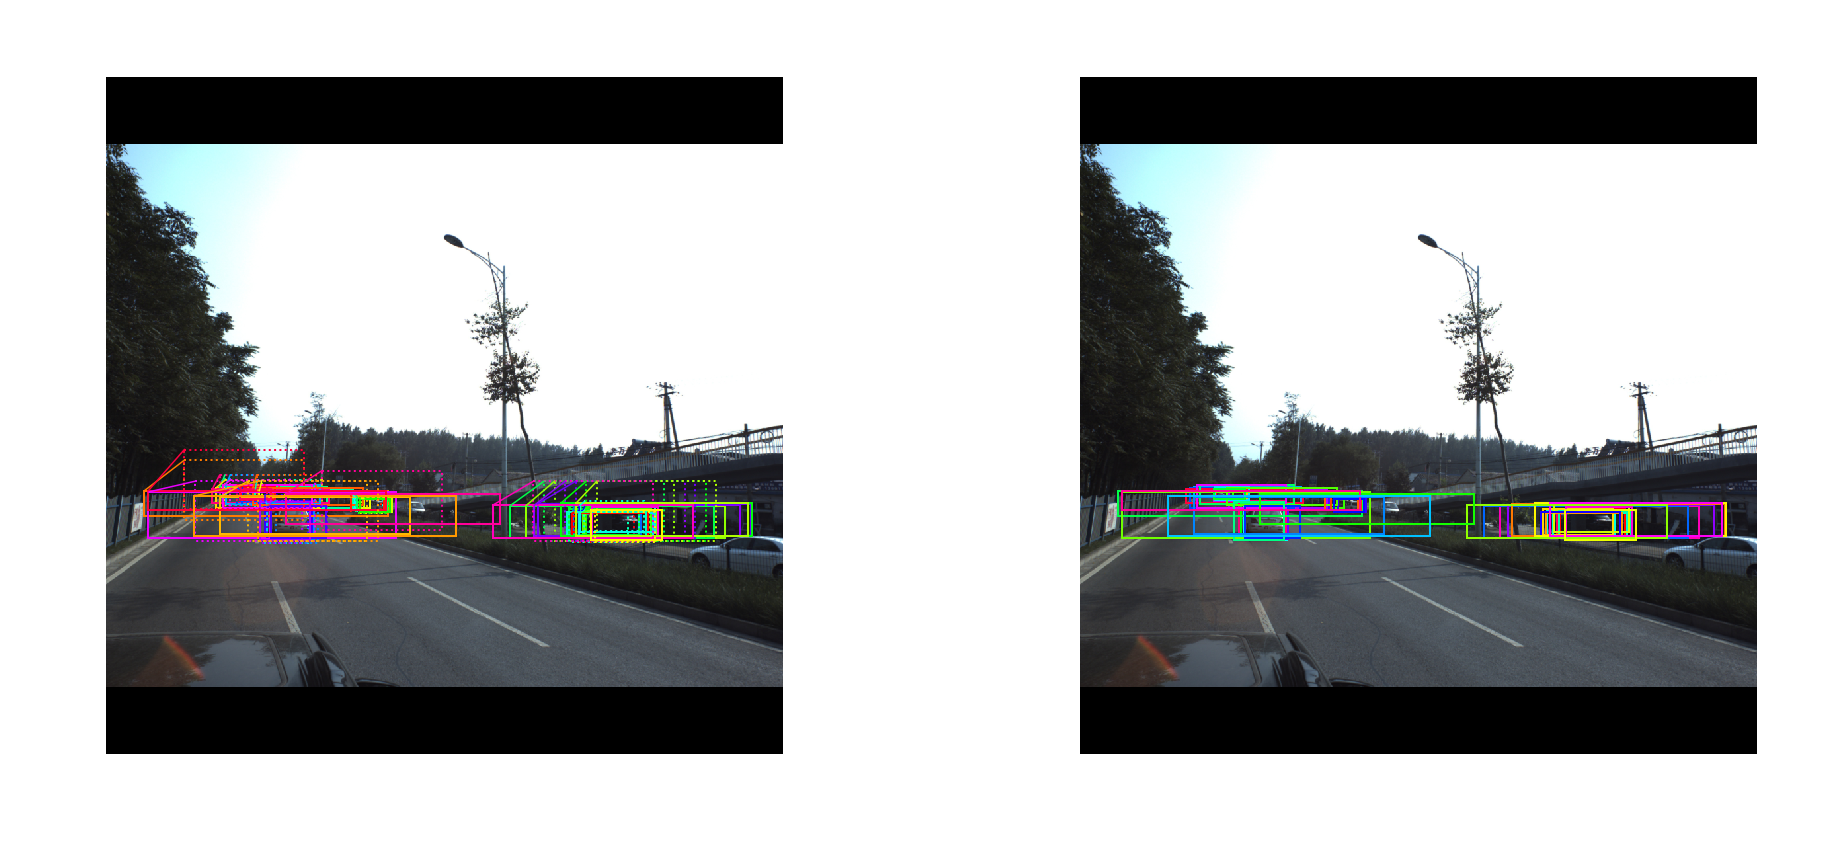

In [32]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

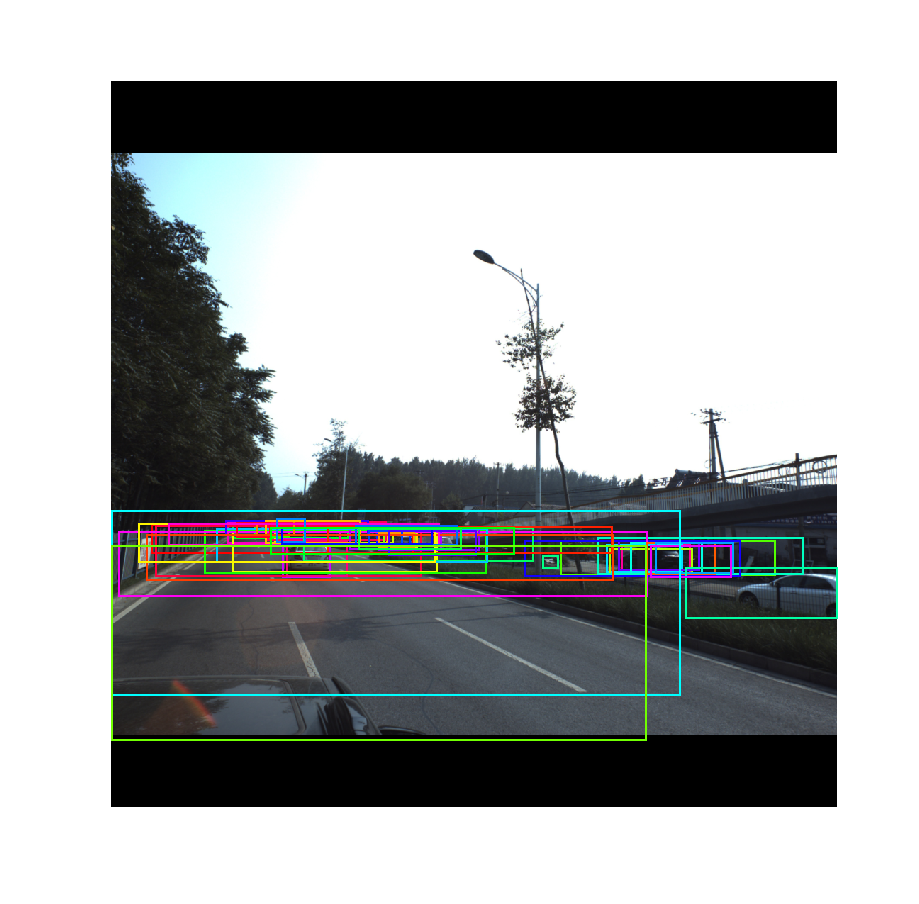

In [33]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

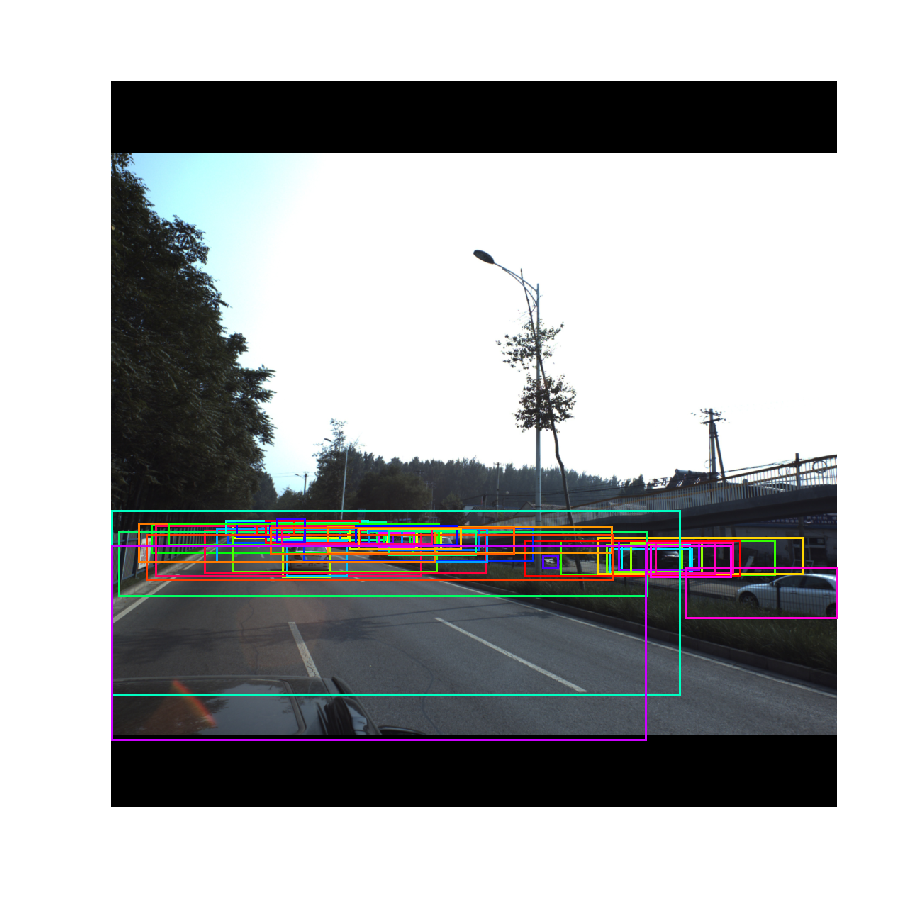

In [34]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [35]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 37)         min:    0.00000  max:    1.00000
deltas                   shape: (1, 1000, 37, 4)      min:   -6.21564  max:    4.87234
masks                    shape: (1, 100, 28, 28, 37)  min:    0.00000  max:    1.00000
detections               shape: (1, 100, 6)           min:    0.00000  max: 1015.00000


3 detections: ['bus' 'car' 'car']


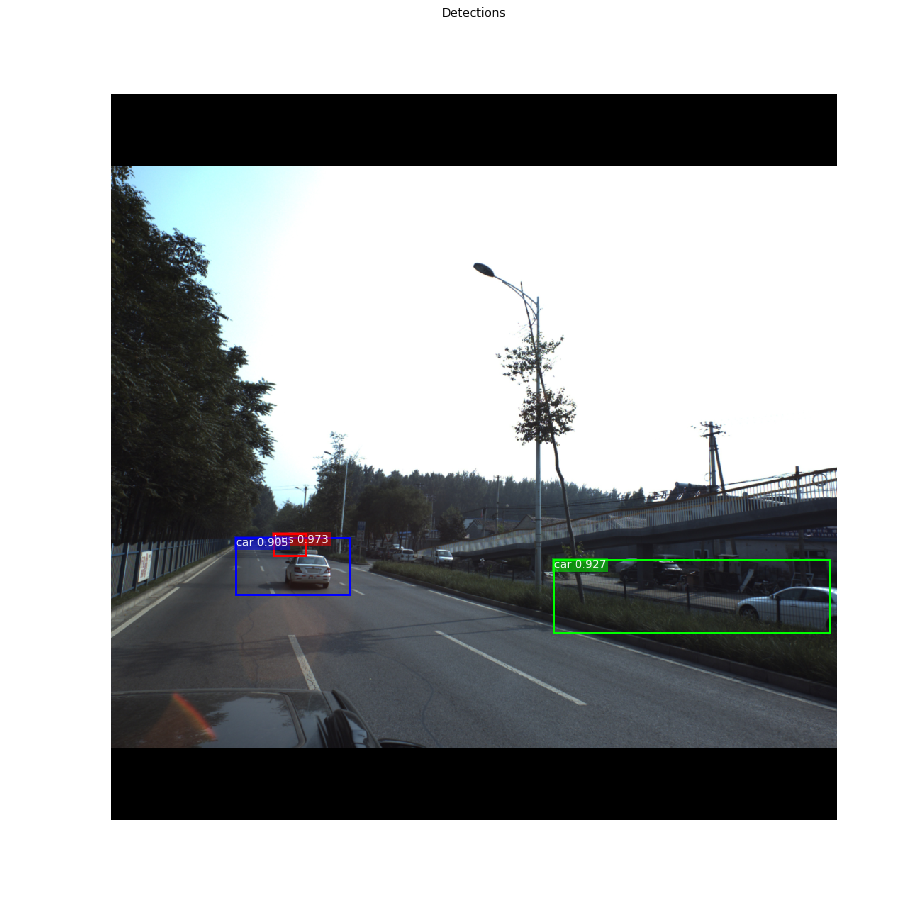

In [36]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [37]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
183 Positive ROIs
[('BG', 817), ('bus', 30), ('car', 152), ('traffic_cone', 1)]


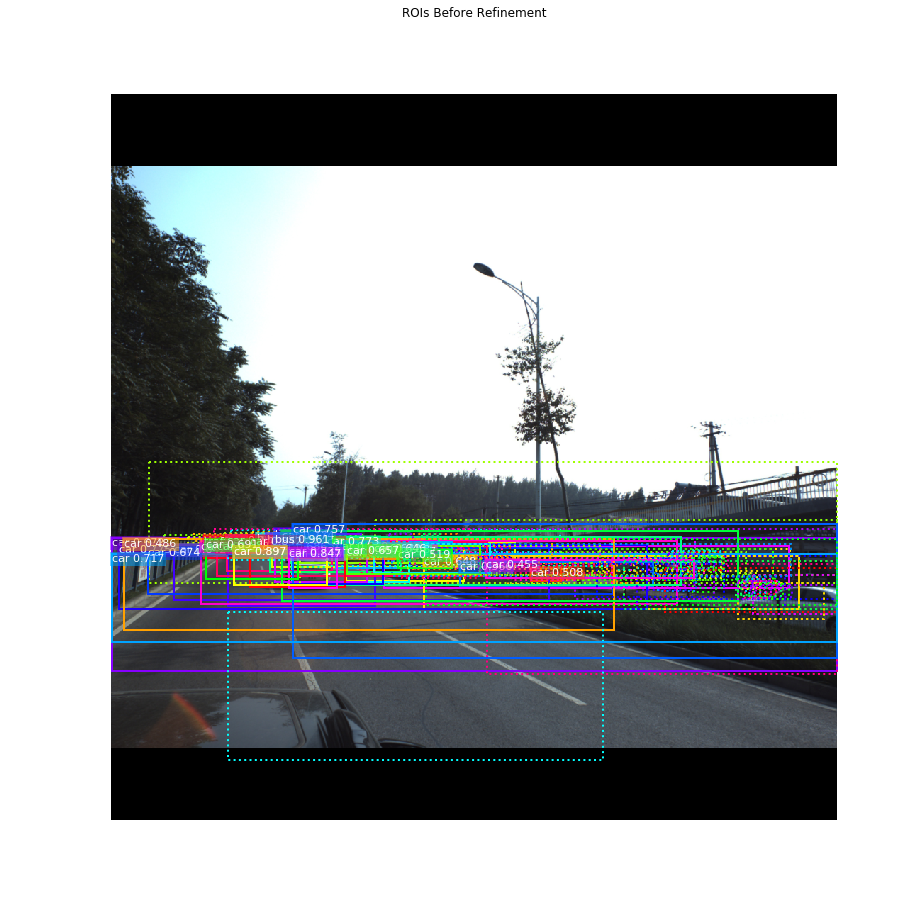

In [38]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -4.11798  max:    3.73276
refined_proposals        shape: (1000, 4)             min: -520.00000  max: 1254.00000


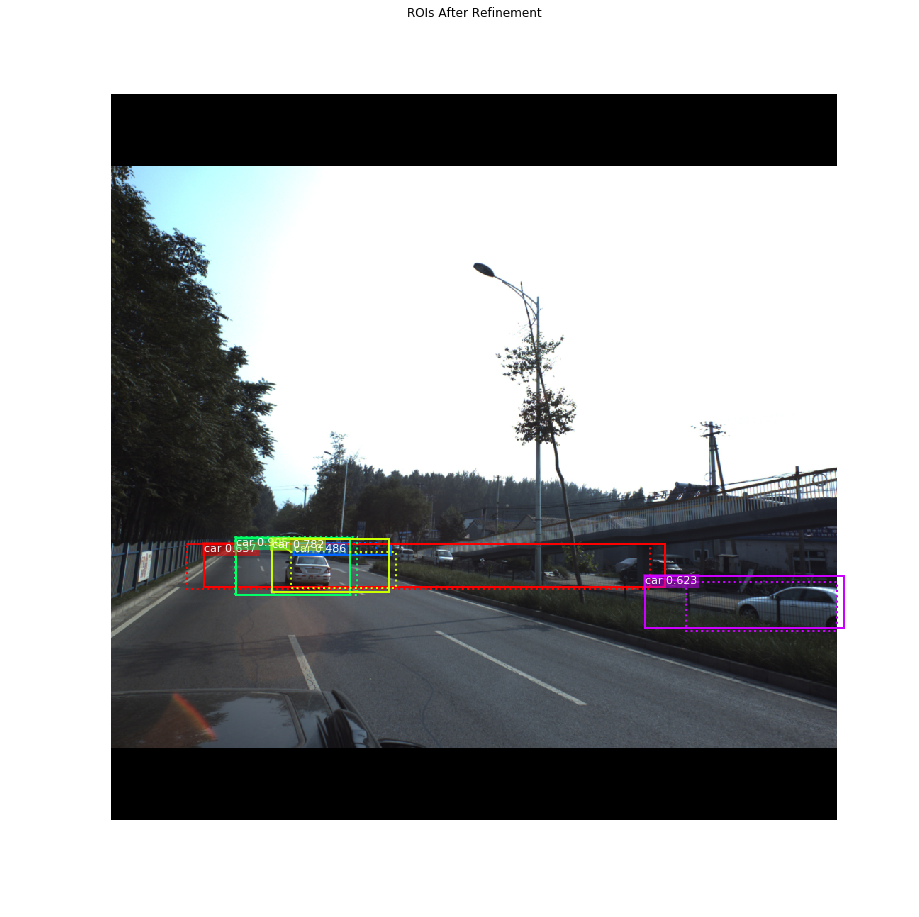

In [39]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [40]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 183 detections:
[  1   3   5   9  11  12  14  16  17  19  20  21  23  26  27  30  32  34
  35  36  37  38  39  40  43  44  46  47  48  52  58  59  60  63  65  66
  68  69  72  83  85  86  90  93  95  96  97 100 103 105 109 110 112 113
 114 118 119 123 133 134 141 142 144 148 149 151 158 159 161 164 165 171
 183 184 185 188 193 194 197 201 207 209 210 221 232 245 246 247 252 253
 256 257 263 271 272 274 276 284 290 291 299 301 303 309 310 314 315 324
 329 334 335 337 340 348 349 352 358 376 382 392 395 398 401 415 417 424
 427 436 438 445 449 450 458 459 462 471 490 500 506 521 542 543 547 553
 562 589 598 605 614 623 631 632 637 638 641 660 680 700 724 737 751 764
 778 780 781 800 802 818 820 821 859 867 870 871 884 891 896 903 921 930
 944 958 963]


In [41]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 14:
[ 40  83 171 232 290 337 398 490 506 521 542 562 632 963]


#### Per-Class Non-Max Suppression

In [42]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

car                   : [290 398] -> [290 398]
bus                   : [ 40  83 171 232 337 490 506 521 542 562 632 963] -> [40]

Kept after per-class NMS: 3
[ 40 290 398]


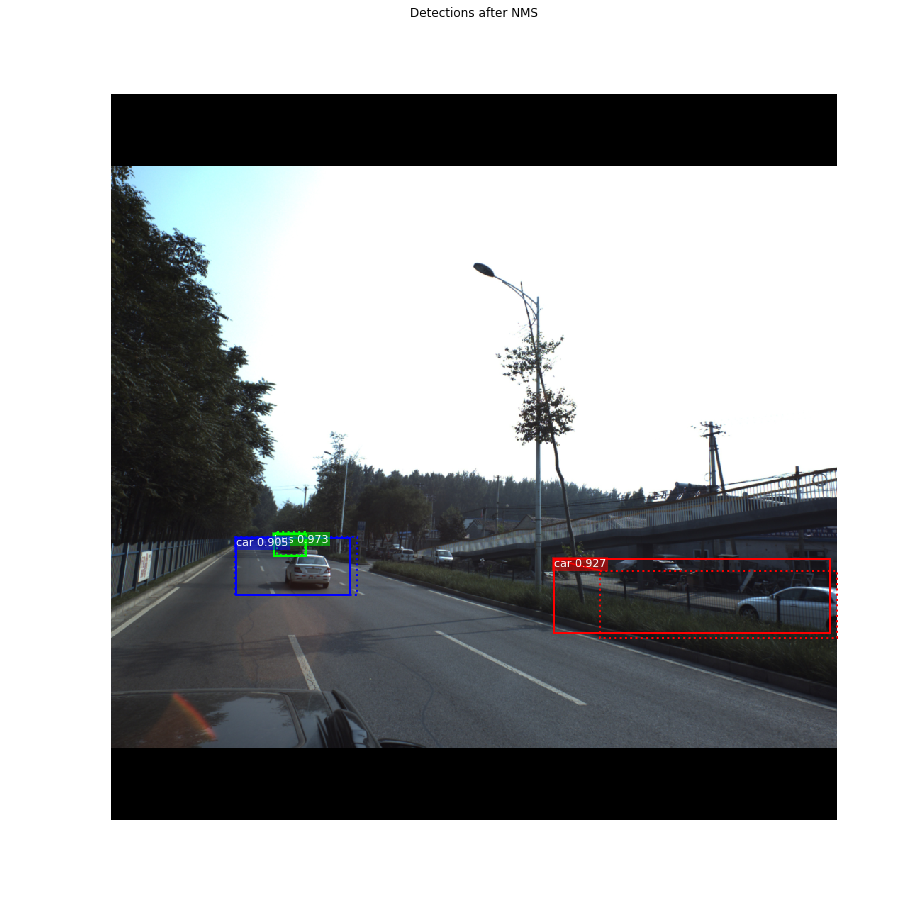

In [43]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

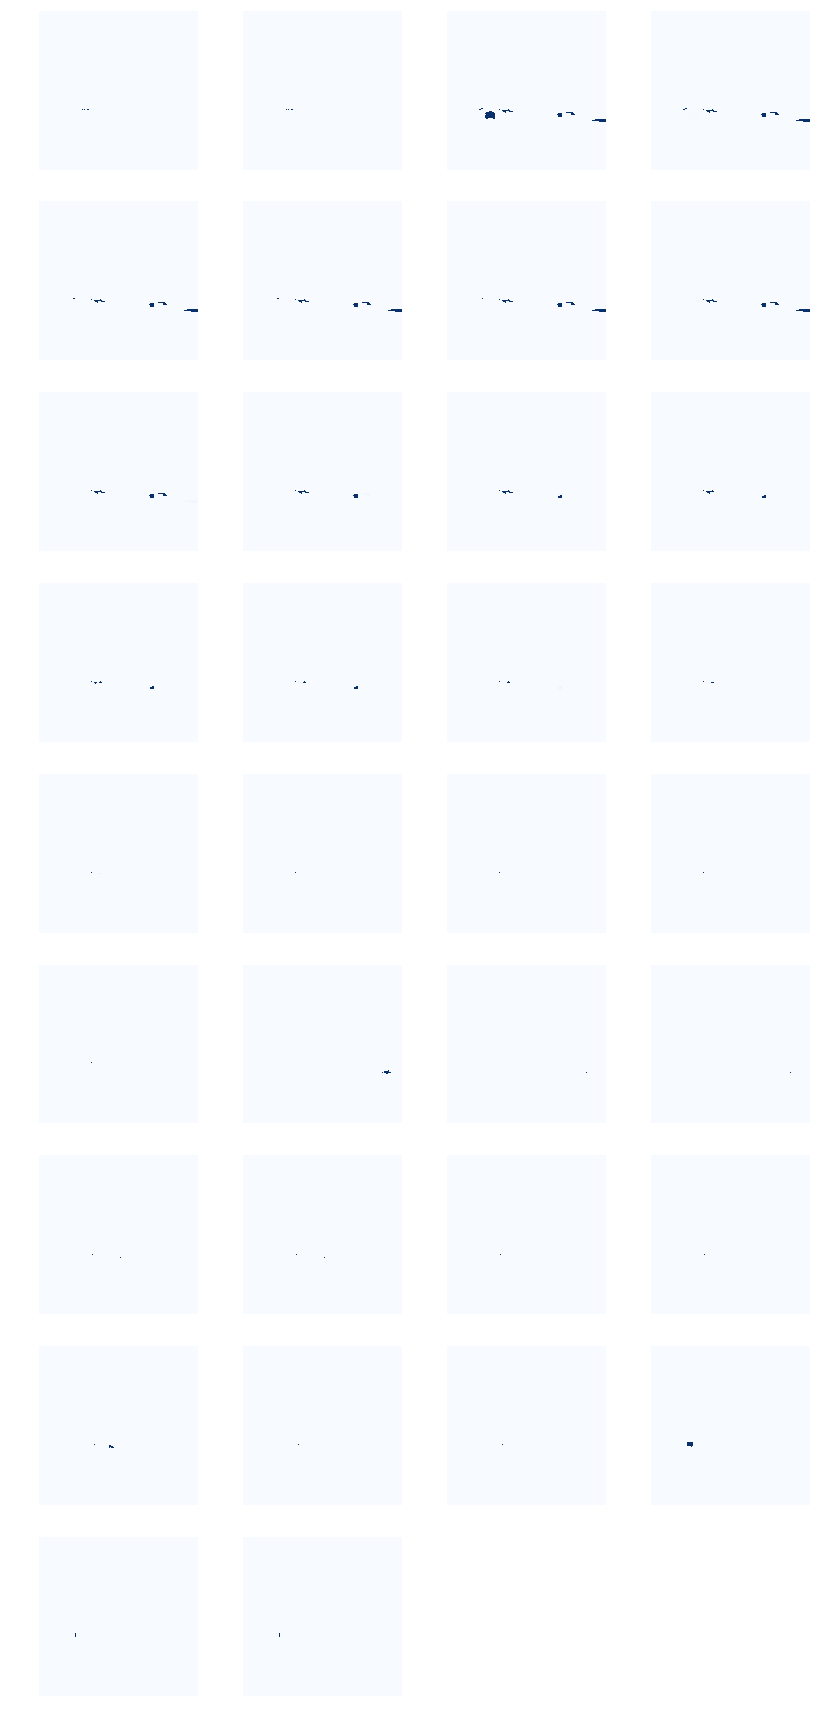

In [44]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [45]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max: 1015.00000
masks                    shape: (1, 100, 28, 28, 37)  min:    0.00000  max:    1.00000
3 detections: ['bus' 'car' 'car']


In [46]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (3, 28, 28)           min:    0.00000  max:    0.98253
det_masks                shape: (3, 1024, 1024)       min:    0.00000  max:    1.00000


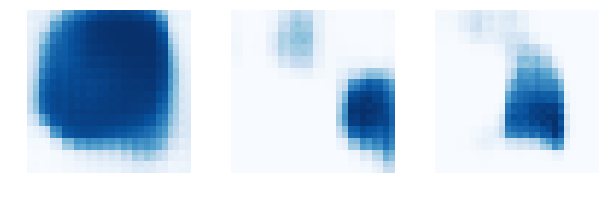

In [47]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

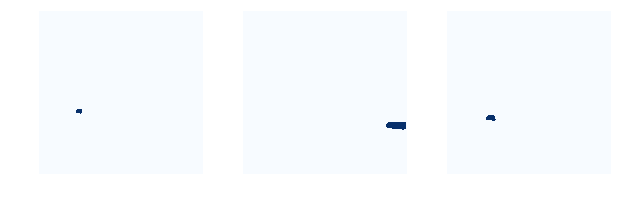

In [48]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [49]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   25.42783
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   28.80073
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   58.10033
rpn_bbox                 shape: (1, 261888, 4)        min:  -11.88833  max:   56.63334
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


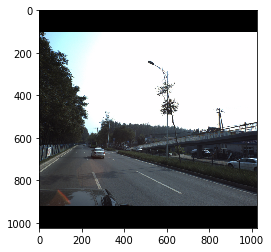

In [50]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

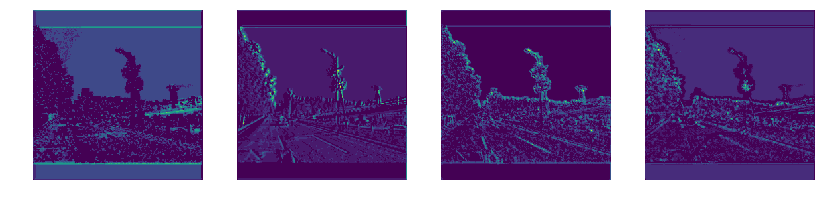

In [51]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

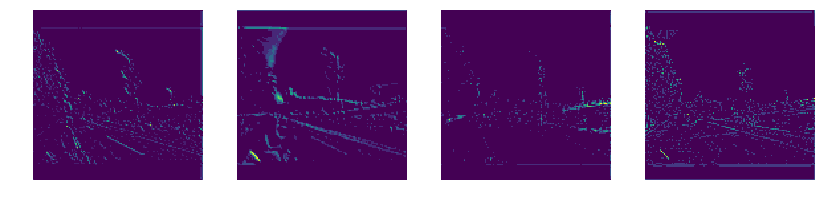

In [55]:
display_images(np.transpose(activations["res3c_out"][0,:,:,:4], [2, 0, 1]), cols=4)

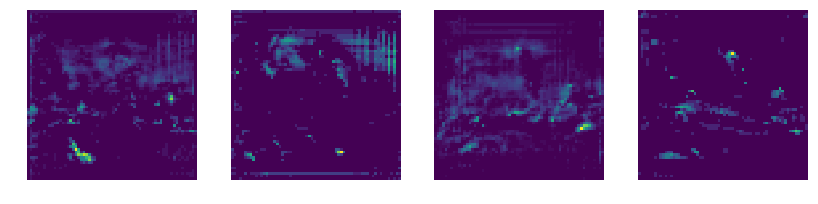

In [57]:
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]), cols=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


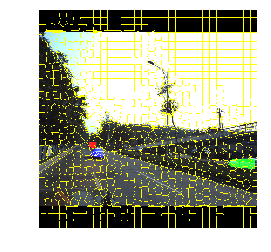

In [86]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import argparse
 
numSegments=1000

segments = slic(image, n_segments = numSegments, sigma = 5)
 
# show the output of SLIC
fig = plt.figure("Superpixels -- %d segments" % (numSegments))
#ax = fig.add_subplot(1, 1, 1)
plt.imshow(mark_boundaries(image, segments)+np.moveaxis(det_masks[:4], 0, -1))
plt.axis("off")
 
# show the plots
plt.show()

In [90]:
mrcnn["masks"].shape

(1, 100, 28, 28, 37)